In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import sys

sys.path.insert(0, '/home/aew492/CFE_gradients')
from generate_mock_list import MockSet

In [3]:
data_dir = '/scratch/aew492/CFE_gradients_output'

In [4]:
def point_on_line(omegahat, t, O=[0,0,0]):
    """Returns (x,y,z) coordinates for a parameterized line."""
    Ox, Oy, Oz = O
    wx, wy, wz = omegahat
    x = Ox + wx*t
    y = Oy + wy*t
    z = Oz + wz*t
    return np.array([x,y,z])

The game plan is
1. find $t$ where plane and line intersect
2. plug $t$ into point_on_line() to get location $\vec{x}$ at which to evaluate $\xi$ with the CFE

Equation for a plane is
$$
n_x (x-a_x) + n_y (y-a_y) + n_z (z-a_z) = 0
$$

where $\vec{n}=(n_x,n_y,n_z)$ is the normal vector to the plane and $\vec{a}=(a_x,a_y,a_z)$ is a point on the plane.

If we plug the parameterization for a line $\vec{x}=\vec{O} + v\hat{\omega}$ into this equation:

\begin{equation}
    n_x (O_x+\omega_x t-a_x) + n_y (O_y+\omega_y t-a_y) + n_z (O_z+\omega_z t-a_z) = 0 \\
    n_x \omega_x t + n_x(O_x-a_x) + n_y \omega_y t + n_y(O_y-a_y) + n_z \omega_z t + n_z(O_z-a_z) = 0 \\
    n_x \omega_x t + n_y \omega_y t + n_z \omega_z t + n_x(O_x-a_x) + n_y(O_y-a_y) + n_z(O_z-a_z) = 0 \\
    n_x \omega_x t + n_y \omega_y t + n_z \omega_z t = - n_x(O_x-a_x) - n_y(O_y-a_y) - n_z(O_z-a_z) \\
    t (n_x \omega_x + n_y \omega_y + n_z \omega_z) = - n_x(O_x-a_x) - n_y(O_y-a_y) - n_z(O_z-a_z) \\
    t (n_x \omega_x + n_y \omega_y + n_z \omega_z) = n_x(a_x-O_x) + n_y(a_y-O_y) + n_z(a_z-O_z)
\end{equation}

So
\begin{align}
t &= [ n_x(a_x-O_x) + n_y(a_y-O_y) + n_z(a_z-O_z) ]\ /\ (n_x \omega_x + n_y \omega_y + n_z \omega_z) \\
    &= [ n_x(a_x-O_x) + n_y(a_y-O_y) + n_z(a_z-O_z) ]\ /\ (\vec{n}\cdot\hat{\omega}) \\
    &= \frac{\hat{n}\cdot\vec{a}\, '}{\hat{n}\cdot\hat{\omega}}\ ,\quad \vec{a}\, '\equiv \vec{a}-\vec{O}
\end{align}

In [5]:
def t_intersect(omega, n, a, O):
    # omega = slope of the line
    # n = normal vector to the plane
    # a = point on the plane
    # O = origin
    # ensure unit vectors
    n /= np.linalg.norm(n)
    # print(f"n = {n}")
    omegahat = omega / np.linalg.norm(omega)
    # print(f"omegahat = {omegahat}")
    aprime = np.array(a) - np.array(O)
    # print(f"aprime = {aprime}")
    A = np.dot(n, aprime)
    # print(f"n dot aprime = {A}")
    B = np.dot(n, omegahat)
    # print(f"n dot omegahat = {B}")
    if B==0:
        print("this line and plane are parallel!")
        t = np.inf
    else:
        t = np.dot(n, aprime) / np.dot(n, omegahat)
    return t

In [6]:
# test: 1D gradient intersecting yz-plane
omegahat = [1,0,0]  # gradient direction
L = 750  # box size
a = [L/2,0,0]  # point on the yz-plane box edge
n = [1,0,0]  # vector normal to the yz-plane
O = [0,0,0]  # center of the box

In [7]:
t = t_intersect(omegahat, n, a, O)

In [8]:
point_on_line(omegahat, t)

array([375.,   0.,   0.])

In [9]:
# test with 3D diagonal gradient intersecting yz-plane again
omega = [1,1,1]
omegahat = omega / np.linalg.norm(omega)
L = 750
a = [L/2,0,0]
n = [1,0,0]
O = [0,0,0]

In [10]:
t = t_intersect(omegahat, n, a, O)
print(t)
point_on_line(omegahat, t)

649.5190528383289


array([375., 375., 375.])

In [11]:
def compute_v(omega, L, O=[0,0,0]):
    omegahat = omega / np.linalg.norm(omega)  # ensure unit vector
    amag = L/2  # distance to each box face
    # test intersection with yz-plane first
    comps = {0 : 'yz',
             1 : 'xz',
             2 : 'xy'}
    ts = []
    for i in comps:
        # construct unit vector
        n = np.zeros(3)
        n[i] = 1
        a = amag * n
        t = t_intersect(omegahat, n, a, O)  # time to intersect with 
        ts.append(np.abs(t))
        print(f"t = {t:.1f} for the {comps[i]}-plane")
    v = min(ts)  # the way we parameterize means that t is just the physical distance to the box edge
    comps_intersect = np.where(ts==v)[0][0]  # will be just one component unless omega is parallel to some face
    print(f"line will intersect first with the {comps[comps_intersect]} plane")
    return v

In [12]:
omega = [1,1,0]
# we expect the line to intersect first with the yz-plane
compute_v(omega, L)

t = 530.3 for the yz-plane
t = 530.3 for the xz-plane
this line and plane are parallel!
t = inf for the xy-plane
line will intersect first with the yz plane


530.3300858899106

Now we can use compute_xi_locs() (currently in image_tools.py) to evaluate $\xi$ at locations according to
$$
\vec{x} = \vec{x}_0 + v\hat{\omega}
$$
where we pivot around $\vec{x}_0 = (L/2, L/2, L/2)$, the center of the box.

### $\hat{\omega} =$ random 3D direction; $L=750$

In [13]:
xi_locs_dict = np.load(os.path.join(data_dir, 'plot_data/xi_locs_L750_n2e-4_z057_patchy_As2x_rlz0_m-0.500-L_b-0.500_50vs.npy'), allow_pickle=True).item()
w_cont05 = xi_locs_dict['w_cont']
vs05 = xi_locs_dict['vs']
r_fine05 = xi_locs_dict['r_fine']
xi_locs05 = xi_locs_dict['xi_locs']

In [14]:
# overplot the non-gradient cfe results
xi_cfe05 = np.load(os.path.join(data_dir, 'gradient/3D/random_omegas/L750_n2e-4_z057_patchy_As2x/suave/xi/bao_iterative/xi_L750_n2e-4_z057_patchy_As2x_rlz0_m-0.500-L_b-0.500.npy'), allow_pickle=True)[:,1]

In [15]:
# color map
vmin05 = min(vs05)
vmax05 = max(vs05)
print(vmin05, vmax05)
vs_norm05 = matplotlib.colors.Normalize(vmin=vmin05, vmax=vmax05)
cmap = matplotlib.cm.get_cmap('cool')
cbar_label05 = r'$v \,\, (\mathbf{x} = \mathbf{x}_0 + v\hat{\omega})$'

-399.0099769947633 399.0099769947633


Text(0.5, 1.0, '$\\vec{\\omega}=$[ -0.001038, 0.000308, 0.000219 ]')

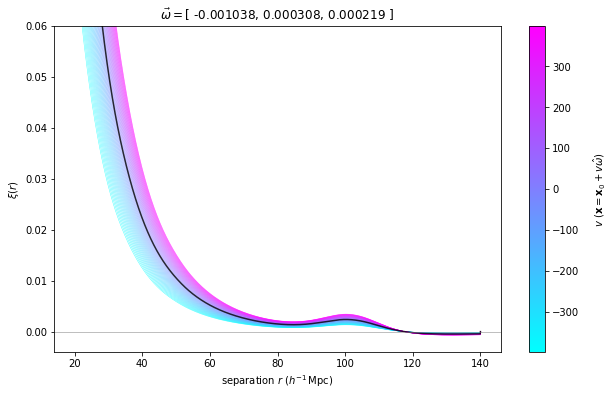

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

for i, v in enumerate(vs05):
    p = ax.plot(r_fine05, xi_locs05[i], color=cmap(vs_norm05(v)), lw=0.5, alpha=0.7)
ax.plot(r_fine05, xi_cfe05, color='k', alpha=0.8)
sm05 = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm05)
cbar = plt.colorbar(sm05)
cbar.set_label(cbar_label05, rotation=90, labelpad=12)
ax.axhline(0, color='grey', lw=0.5)
ax.set_ylim((-0.004, 0.06))
ax.set_xlabel(r"separation $r$ ($h^{-1}\,$Mpc)")
ax.set_ylabel(r"$\xi(r)$")
ax.set_title(r"$\vec{\omega}=$"+f"[ {w_cont05[0]:.6f}, {w_cont05[1]:.6f}, {w_cont05[2]:.6f} ]")

### $\hat{\omega} = [1, 0, 0]$; $L=750$

In [17]:
xi_locs_dict = np.load(os.path.join(data_dir, 'plot_data/xi_locs_L750_n2e-4_z057_patchy_As2x_rlz0_m-1.000-L_b-0.500_50vs.npy'), allow_pickle=True).item()
w_cont1 = xi_locs_dict['w_cont']
vs1 = xi_locs_dict['vs']
r_fine1 = xi_locs_dict['r_fine']
xi_locs1 = xi_locs_dict['xi_locs']

In [18]:
# overplot the non-gradient cfe results
xi_cfe1 = np.load(os.path.join(data_dir, 'gradient/1D/same_omega/L750_n2e-4_z057_patchy_As2x/suave/xi/bao_iterative/xi_L750_n2e-4_z057_patchy_As2x_rlz0_m-1.000-L_b-0.500.npy'), allow_pickle=True)[:,1]

In [19]:
# color map
vmin1 = min(vs1)
vmax1 = max(vs1)
print(vmin1, vmax1)
vs_norm1 = matplotlib.colors.Normalize(vmin=vmin1, vmax=vmax1)
cmap = matplotlib.cm.get_cmap('cool')
cbar_label = r'$v \,\, (\mathbf{x} = \mathbf{x}_0 + v\hat{\omega})$'

-390.64658945709954 390.64658945709954


Text(0.5, 1.0, '$\\vec{\\omega}=$[ 0.001430, 0.000376, 0.000181 ]')

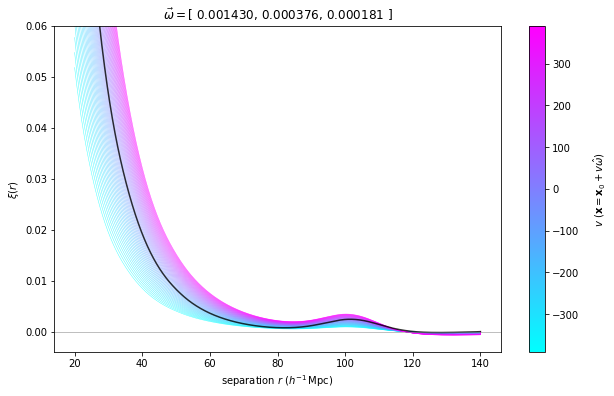

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

for i, v in enumerate(vs1):
    p = ax.plot(r_fine1, xi_locs1[i], color=cmap(vs_norm1(v)), lw=0.5, alpha=0.7)
ax.plot(r_fine1, xi_cfe1, color='k', alpha=0.8)
sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm1)
cbar = plt.colorbar(sm1)
cbar.set_label(cbar_label, rotation=90, labelpad=12)
ax.axhline(0, color='grey', lw=0.5)
ax.set_ylim((-0.004, 0.06))
ax.set_xlabel(r"separation $r$ ($h^{-1}\,$Mpc)")
ax.set_ylabel(r"$\xi(r)$")
ax.set_title(r"$\vec{\omega}=$"+f"[ {w_cont1[0]:.6f}, {w_cont1[1]:.6f}, {w_cont1[2]:.6f} ]")

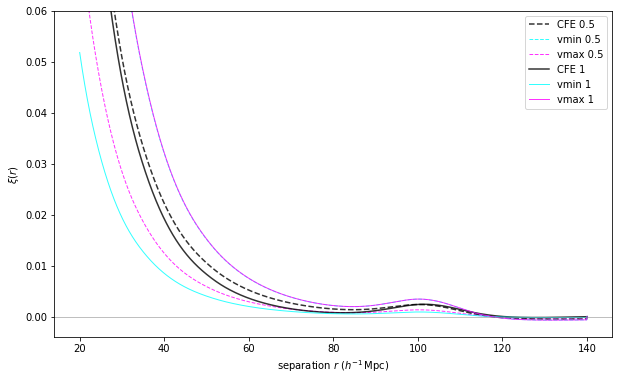

In [21]:
# plot both on the same?
fig, ax = plt.subplots(figsize=(10,6))

# m=0.5
ax.plot(r_fine05, xi_cfe05, color='k', ls='--', alpha=0.8, label='CFE 0.5') # normal cfe
ax.plot(r_fine05, xi_locs05[0], color=cmap(vs_norm05(vmin05)), ls='--', lw=1, alpha=0.8, label='vmin 0.5') # vmin
ax.plot(r_fine05, xi_locs05[-1], color=cmap(vs_norm05(vmax05)), ls='--', lw=1, alpha=0.8, label='vmax 0.5') # vmax

# m=1
ax.plot(r_fine1, xi_cfe1, color='k', alpha=0.8, label='CFE 1') # normal cfe
ax.plot(r_fine1, xi_locs1[0], color=cmap(vs_norm1(vmin1)), lw=1, alpha=0.8, label='vmin 1') # vmin
ax.plot(r_fine1, xi_locs1[-1], color=cmap(vs_norm1(vmax1)), lw=1, alpha=0.8, label='vmax 1') # vmax

ax.axhline(0, color='grey', lw=0.5)
ax.set_ylim((-0.004, 0.06))
ax.set_xlabel(r"separation $r$ ($h^{-1}\,$Mpc)")
ax.set_ylabel(r"$\xi(r)$")
ax.legend()

Now we need to figure out patches: projecting each patch center $P=(p_x,p_y,p_z)$ onto the line $\vec{x}=\vec{x}_0+v\hat{\omega}\ \longrightarrow\ \vec{x}=\vec{O}+\hat{\omega}$.

In [21]:
L = 750
n = '2e-4'
rlzs = 1
mockset = MockSet(L, n, rlzs=rlzs)

In [22]:
# get the t at which the line and plane intersect
P = [L/4, L/4, L/4]
O = [0,0,0]
omega = [1,1,0]
omegahat = omega / np.linalg.norm(omega)
td = t_intersect(omega, omega, P, O)
td

265.16504294495536

In [23]:
point_on_line(omegahat, td)

array([187.5, 187.5,   0. ])

In [24]:
mockset.add_gradient(grad_dim=3, m=0.75, b=0.5, same_dir=False)

In [31]:
# load in xi patches
rlz = 0
patches_dict = np.load(os.path.join(data_dir, f'{mockset.mock_path}/patches/8patches/grad_amps/{mockset.mock_fn_list[rlz]}.npy'), allow_pickle=True).item()
r_avg = patches_dict['r_avg']
xi_patches = patches_dict['xi_patches'] # L-S evaluated in each patch
patch_centers = patches_dict['patch_centers']
w_patch = (patches_dict['theta'][1:]/patches_dict['theta'][0]).flatten()

In [32]:
# Landy-Szalay results
r_avg, xi_ls = np.load(os.path.join(data_dir, f'{mockset.mock_path}/ls/xi_ls_3x_{mockset.mock_fn_list[rlz]}.npy'), allow_pickle=True)

Text(0, 0.5, '$\\xi(r)$')

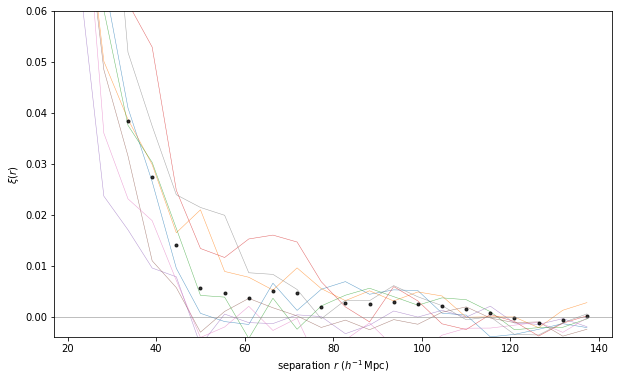

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

for i, xi_patch in enumerate(xi_patches):
    p = ax.plot(r_avg, xi_patches[i], lw=0.5, alpha=0.7)
# ax.plot(r_fine, xi_cfe, color='k', alpha=0.8)
ax.plot(r_avg, xi_ls, marker='.', color='k', ls='None', alpha=0.8)
ax.axhline(0, color='grey', lw=0.5)
ax.set_ylim((-0.004, 0.06))
ax.set_xlabel(r"separation $r$ ($h^{-1}\,$Mpc)")
ax.set_ylabel(r"$\xi(r)$")

In [34]:
# now we try to color by projection along gradient direction

In [37]:
# get min and max distance from origin along gradient line
vmax = compute_v(w_patch, L, O)
vmax

t = -901.2 for the yz-plane
t = 627.4 for the xz-plane
t = 547.2 for the xy-plane
line will intersect first with the xy plane


547.2291296787846

In [38]:
vs_norm_patch = matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax)

In [43]:
vs = []
for i, patch_center in enumerate(patch_centers):
    P = patch_center - L/2 # -L/2 to center at 0
    omegahat = w_patch / np.linalg.norm(w_patch)
    td = t_intersect(omegahat, omegahat, P, O)
    print(td)
    vs.append(td)

-162.6087967971922
93.57432639448567
62.16868619877587
319.4013917046223
-318.58170705660524
-61.80487908239583
-94.55065624205488
162.54501401558548


Text(0.5, 1.0, '$\\vec{\\omega}=$[-0.00160909  0.00231138  0.00264996]')

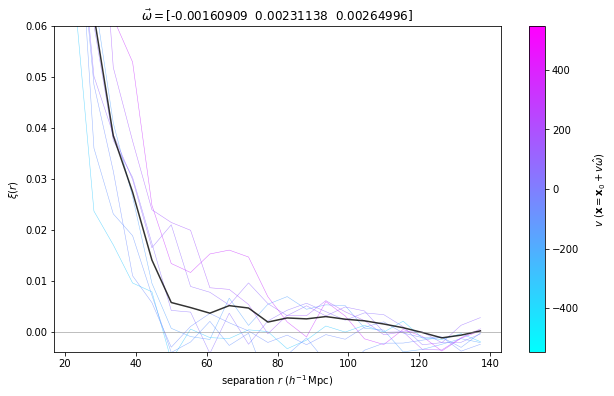

In [44]:
fig, ax = plt.subplots(figsize=(10,6))

for i, v in enumerate(vs):
    p = ax.plot(r_avg, xi_patches[i], color=cmap(vs_norm_patch(v)), lw=0.5, alpha=0.7, label=patch_centers[i])
ax.plot(r_avg, xi_ls, color='k', alpha=0.8, label='Landy-Szalay') # LS results
sm = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm_patch)
cbar = plt.colorbar(sm)
cbar.set_label(cbar_label, rotation=90, labelpad=12)
ax.axhline(0, color='grey', lw=0.5)
ax.set_ylim((-0.004, 0.06))
ax.set_xlabel(r"separation $r$ ($h^{-1}\,$Mpc)")
ax.set_ylabel(r"$\xi(r)$")
ax.set_title(r"$\vec{\omega}=$"+f"{w_patch}")